## HW5 by Denis Osipychev
# Policy Gradient

### Hyper parameters and service functions

In [3]:
# import env and modules
import gym
import numpy as np
import myenv
import random

In [4]:
# create an instance of env
env = myenv.GridWorldEnv()

In [5]:
# initialize hyperparams for PG
n_episodes = 5000
episode_lenght = 100
gamma = 0.9
alpha = 0.001
update_freq = 100
buffer_size = 1000
batch_size = 100

In [6]:
# initialize random policy weights
def policy_init():
    #policy = np.zeros([env.observation_space.n, env.action_space.n])
    policy = np.random.rand(env.observation_space.n, env.action_space.n)-0.5
    return policy

In [7]:
# function to discount reward in trajectory
def discount_rewards(r):
    discounted_reward = np.zeros_like(r)
    running_reward = 0
    for t in reversed(range(0,len(r))):
        running_reward = running_reward*gamma + r[t]
        discounted_reward[t] = running_reward
    return discounted_reward

In [8]:
# stable softmax (taken from https://deepnotes.io/softmax-crossentropy)
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, arg):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)
    
    def size(self):
        return len(self.memory)

In [10]:
# print a policy (taken from Dr. West solution and adapted)
def print_policy(policy_matrix):
    output = ''
    k = 0
    for i in range(5):
        for j in range(5):
            if len(policy_matrix.shape) == 2:
                s = i*5 + j
                a = policy_matrix[s,:].argmax()
            else:
                a = policy_matrix[i,j,:].argmax()
            c = [u"⇧",u"⇩",u"⇦",u"⇨"][a]
            output += c
            k += 1
        output += '\n'
    return output

### Policy Gradient - REINFORCE with Causality

In [11]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient(policy, s_arr, a_arr, r_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * r_arr[t] #accumulate gradients through trajectory
    return g

In [12]:
# PG REINFORCE algorithm
def PolicyGrad(policy):
    stats = []
    trajectory_buffer = ReplayMemory(buffer_size)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()[:]
        trajectory = []
            
        for t in range(episode_lenght):
        
            s_flat = s[0] * 5 + s[1] #flatter state from 2D to 1D to simplify policy matrix
            a_distr = softmax(policy[s_flat]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s_flat,a,r])
                
            s = s_prime[:]
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with new trajectory
            grad_buffer = np.zeros_like(policy)
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr = zip(*traj)
                r_arr = discount_rewards(r_arr)
                grad = gradient(policy, s_arr, a_arr, r_arr)
                grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
            trajectory_buffer = ReplayMemory(buffer_size)
        
        # Update statistics
        stats.append([i_episode,r_total])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,',Average R:',np.mean(np.asarray(stats)[-100:,1]))
    
    return policy,stats

In [13]:
# run the algorithm to get statistics (simple env)
env.stochastic_transitions = False
policy = policy_init()
policy, statsPGwCa = PolicyGrad(policy)

# run the algorithm to get statistics (complex env)
env.stochastic_transitions = True
policy = policy_init()
policy, statsPGwCb = PolicyGrad(policy)

 Epoch: 0 ,Average R: -21.0
 Epoch: 100 ,Average R: -7.17
 Epoch: 200 ,Average R: 6.31
 Epoch: 300 ,Average R: 19.29
 Epoch: 400 ,Average R: 34.91
 Epoch: 500 ,Average R: 64.18
 Epoch: 600 ,Average R: 100.89
 Epoch: 700 ,Average R: 129.04
 Epoch: 800 ,Average R: 145.05
 Epoch: 900 ,Average R: 150.16
 Epoch: 1000 ,Average R: 151.31
 Epoch: 1100 ,Average R: 153.6
 Epoch: 1200 ,Average R: 149.84
 Epoch: 1300 ,Average R: 152.27
 Epoch: 1400 ,Average R: 154.0
 Epoch: 1500 ,Average R: 154.97
 Epoch: 1600 ,Average R: 153.64
 Epoch: 1700 ,Average R: 154.6
 Epoch: 1800 ,Average R: 154.04
 Epoch: 1900 ,Average R: 155.83
 Epoch: 2000 ,Average R: 156.39
 Epoch: 2100 ,Average R: 156.89
 Epoch: 2200 ,Average R: 156.77
 Epoch: 2300 ,Average R: 156.78
 Epoch: 2400 ,Average R: 157.18
 Epoch: 2500 ,Average R: 157.84
 Epoch: 2600 ,Average R: 158.76
 Epoch: 2700 ,Average R: 158.21
 Epoch: 2800 ,Average R: 159.74
 Epoch: 2900 ,Average R: 158.63
 Epoch: 3000 ,Average R: 159.04
 Epoch: 3100 ,Average R: 160.3

In [15]:
print("Policy:")
print(print_policy(policy))

Policy:
⇦⇦⇦⇦⇧
⇩⇧⇧⇧⇧
⇨⇧⇧⇧⇧
⇧⇧⇧⇧⇧
⇨⇨⇨⇧⇧



### Policy Gradient - REINFORCE with Off-Policy Learning

In [16]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_off_policy(policy, s_arr, a_arr, r_arr, l_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    likelihood = 1
    for t in range(n):
        likelihood *= softmax(policy[s_arr[t]])[a_arr[t]]
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + likelihood/l_arr[t] * dp * r_arr[t] #accumulate gradients through trajectory
    return g

In [17]:
# PG REINFORCE algorithm with Off Line Policy
def PolicyGrad_OffPolicy(policy):
    stats = []
    trajectory_buffer = ReplayMemory(1000)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()[:]
        trajectory = []
        likelihood = 1
            
        for t in range(episode_lenght):
        
            s_flat = s[0] * 5 + s[1] #flatter state from 2D to 1D to simplify policy matrix
            a_distr = softmax(policy[s_flat]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)
            
            # compute lh for current policy to store it
            likelihood *= a_distr[a]
            trajectory.append([s_flat,a,r,likelihood])
                
            s = s_prime[:]
            r_total += r
                
            if d:
                break
                
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with new trajectory
            grad_buffer = np.zeros_like(policy)
            batch = trajectory_buffer.sample(100)
            for traj in batch:
                s_arr, a_arr, r_arr, l_arr = zip(*traj)
                r_arr = discount_rewards(r_arr)
                grad = gradient_off_policy(policy, s_arr, a_arr, r_arr, l_arr)
                grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
        
        # Update statistics
        stats.append([i_episode,r_total])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,',Average R:',np.mean(np.asarray(stats)[-100:,1]))
    
    return policy,stats

In [18]:
# run the algorithm to get statistics (simple env)
env.stochastic_transitions = False

policy = policy_init()
policy, statsPGOPa = PolicyGrad_OffPolicy(policy)

# run the algorithm to get statistics (complex env)
env.stochastic_transitions = True

policy = policy_init()
policy, statsPGOPb = PolicyGrad_OffPolicy(policy)

 Epoch: 0 ,Average R: 4.0
 Epoch: 100 ,Average R: -3.58
 Epoch: 200 ,Average R: 7.38
 Epoch: 300 ,Average R: 22.82
 Epoch: 400 ,Average R: 43.66
 Epoch: 500 ,Average R: 64.47
 Epoch: 600 ,Average R: 79.54
 Epoch: 700 ,Average R: 81.48
 Epoch: 800 ,Average R: 83.47
 Epoch: 900 ,Average R: 85.3
 Epoch: 1000 ,Average R: 89.11
 Epoch: 1100 ,Average R: 92.59
 Epoch: 1200 ,Average R: 94.09
 Epoch: 1300 ,Average R: 93.39
 Epoch: 1400 ,Average R: 95.02
 Epoch: 1500 ,Average R: 95.59
 Epoch: 1600 ,Average R: 97.43
 Epoch: 1700 ,Average R: 99.79
 Epoch: 1800 ,Average R: 103.79
 Epoch: 1900 ,Average R: 110.45
 Epoch: 2000 ,Average R: 119.38
 Epoch: 2100 ,Average R: 137.7
 Epoch: 2200 ,Average R: 161.31
 Epoch: 2300 ,Average R: 139.56
 Epoch: 2400 ,Average R: 146.83
 Epoch: 2500 ,Average R: 161.72
 Epoch: 2600 ,Average R: 172.6
 Epoch: 2700 ,Average R: 162.79
 Epoch: 2800 ,Average R: 171.07
 Epoch: 2900 ,Average R: 174.62
 Epoch: 3000 ,Average R: 185.16
 Epoch: 3100 ,Average R: 186.4
 Epoch: 3200 

In [23]:
print("Policy (dificult case):")
print(print_policy(policy))

Policy (dificult case):
⇦⇦⇧⇦⇦
⇨⇧⇧⇧⇧
⇨⇧⇧⇧⇧
⇩⇧⇧⇨⇧
⇨⇨⇨⇨⇧



### Policy Gradient - REINFORCE with Baseline Shift

In [24]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_with_baseline(policy, baseline, s_arr, a_arr, r_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * (r_arr[t] - baseline[s_arr[t]]) #accumulate gradients through trajectory
    return g

In [25]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_of_baseline(policy, baseline, s_arr, a_arr, r_arr):
    n = len(r_arr)
    b = np.zeros_like(baseline)
    for t in reversed(range(n-1)):
        v = softmax(policy[s_arr[t]])[a_arr[t]] * (r_arr[t+1] + gamma * baseline[s_arr[t+1]])
        db = v - baseline[s_arr[t]]
        b[s_arr[t]] = b[s_arr[t]] + db #accumulate gradients through trajectory
    return b

In [26]:
# PG REINFORCE algorithm
def PolicyGradWithBaseline(policy):
    stats = []
    baseline = np.asarray(policy)
    trajectory_buffer = ReplayMemory(buffer_size)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()[:]
        trajectory = []
            
        for t in range(episode_lenght):
        
            s_flat = s[0] * 5 + s[1] #flatter state from 2D to 1D to simplify policy matrix
            a_distr = softmax(policy[s_flat]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s_flat,a,r])
                
            s = s_prime[:]
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with new trajectory
            grad_policy_buffer = np.zeros_like(policy)
            grad_baseline_buffer = np.zeros_like(baseline)
            
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr = zip(*traj)
                r_arr = discount_rewards(r_arr)
                dp = gradient_with_baseline(policy, baseline, s_arr, a_arr, r_arr)
                db = gradient_of_baseline(policy,baseline, s_arr, a_arr, r_arr)
                
                grad_baseline_buffer = grad_baseline_buffer + db
                grad_policy_buffer = grad_policy_buffer + dp #accumulate gradients b/w updates
            
            policy = policy + alpha*grad_policy_buffer
            baseline = baseline + alpha*grad_baseline_buffer
            
            trajectory_buffer = ReplayMemory(buffer_size)
        
        # Update statistics
        stats.append([i_episode,r_total])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,',Average R:',np.mean(np.asarray(stats)[-100:,1]))
    
    return policy,stats

In [27]:
# run the algorithm to get statistics (simple env)
env.stochastic_transitions = False

policy = policy_init()
policy, statsPGBSa = PolicyGradWithBaseline(policy)

# run the algorithm to get statistics (complex env)
env.stochastic_transitions = True

policy = policy_init()
policy, statsPGBSb = PolicyGradWithBaseline(policy)

 Epoch: 0 ,Average R: -8.0
 Epoch: 100 ,Average R: 0.72
 Epoch: 200 ,Average R: 14.54
 Epoch: 300 ,Average R: 31.68
 Epoch: 400 ,Average R: 62.32
 Epoch: 500 ,Average R: 101.66
 Epoch: 600 ,Average R: 133.46
 Epoch: 700 ,Average R: 142.61
 Epoch: 800 ,Average R: 150.48
 Epoch: 900 ,Average R: 153.48
 Epoch: 1000 ,Average R: 155.47
 Epoch: 1100 ,Average R: 160.24
 Epoch: 1200 ,Average R: 164.36
 Epoch: 1300 ,Average R: 168.55
 Epoch: 1400 ,Average R: 168.37
 Epoch: 1500 ,Average R: 166.79
 Epoch: 1600 ,Average R: 113.44
 Epoch: 1700 ,Average R: 138.55
 Epoch: 1800 ,Average R: 117.43
 Epoch: 1900 ,Average R: 131.41
 Epoch: 2000 ,Average R: 133.05
 Epoch: 2100 ,Average R: 142.84
 Epoch: 2200 ,Average R: 163.01
 Epoch: 2300 ,Average R: 170.09
 Epoch: 2400 ,Average R: 158.46
 Epoch: 2500 ,Average R: 173.5
 Epoch: 2600 ,Average R: 181.93
 Epoch: 2700 ,Average R: 182.98
 Epoch: 2800 ,Average R: 184.52
 Epoch: 2900 ,Average R: 177.02
 Epoch: 3000 ,Average R: 11.16
 Epoch: 3100 ,Average R: 2.41

### Absolute the best (All is ON)

In [28]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient1(policy, baseline, s_arr, a_arr, r_arr, l_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    likelihood = 1
    for t in range(n):
        likelihood *= softmax(policy[s_arr[t]])[a_arr[t]]
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + likelihood/l_arr[t] * dp * (r_arr[t] - baseline[s_arr[t]]) #accumulate gradients through trajectory
    return g

In [29]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient2(policy, baseline, s_arr, a_arr, r_arr, l_arr):
    n = len(r_arr)
    b = np.zeros_like(baseline)
    likelihood = 1
    for t in reversed(range(n-1)):
        likelihood *= softmax(policy[s_arr[t]])[a_arr[t]]
        v = softmax(policy[s_arr[t]])[a_arr[t]] * (r_arr[t+1] + gamma * baseline[s_arr[t+1]])
        db = v - baseline[s_arr[t]]
        b[s_arr[t]] = b[s_arr[t]] + likelihood/l_arr[t] * db #accumulate gradients through trajectory
    return b

In [30]:
# PG REINFORCE algorithm
def PolicyGradBest(policy):
    stats = []
    baseline = np.asarray(policy)
    trajectory_buffer = ReplayMemory(buffer_size)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()[:]
        trajectory = []
        likelihood = 1
            
        for t in range(episode_lenght):
        
            s_flat = s[0] * 5 + s[1] #flatter state from 2D to 1D to simplify policy matrix
            a_distr = softmax(policy[s_flat]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            likelihood *= a_distr[a]
            trajectory.append([s_flat,a,r,likelihood])
                
            s = s_prime[:]
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with new trajectory
            grad_policy_buffer = np.zeros_like(policy)
            grad_baseline_buffer = np.zeros_like(baseline)
            
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr, l_arr= zip(*traj)
                r_arr = discount_rewards(r_arr)
                dp = gradient1(policy, baseline, s_arr, a_arr, r_arr, l_arr)
                db = gradient2(policy,baseline, s_arr, a_arr, r_arr, l_arr)
                
                grad_baseline_buffer = grad_baseline_buffer + db
                grad_policy_buffer = grad_policy_buffer + dp #accumulate gradients b/w updates
                
                grad_policy_buffer = np.clip(grad_policy_buffer,-1000,1000)
                grad_baseline_buffer = np.clip(grad_baseline_buffer,-1000,1000)
            
            policy = policy + alpha*grad_policy_buffer
            baseline = baseline + alpha*grad_baseline_buffer
        
        # Update statistics
        stats.append([i_episode,r_total])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,',Average R:',np.mean(np.asarray(stats)[-100:,1]))
    
    return policy,stats

In [31]:
# run the algorithm to get statistics (simple env)
env.stochastic_transitions = False

policy = policy_init()
policy, statsPGALLa = PolicyGradBest(policy)

# run the algorithm to get statistics (simple env)
env.stochastic_transitions = True

policy = policy_init()
policy, statsPGALLb = PolicyGradBest(policy)

 Epoch: 0 ,Average R: 9.0
 Epoch: 100 ,Average R: 1.32
 Epoch: 200 ,Average R: 9.32
 Epoch: 300 ,Average R: 24.03
 Epoch: 400 ,Average R: 43.96
 Epoch: 500 ,Average R: 63.56
 Epoch: 600 ,Average R: 98.35
 Epoch: 700 ,Average R: 117.21
 Epoch: 800 ,Average R: 131.06
 Epoch: 900 ,Average R: 136.62
 Epoch: 1000 ,Average R: 137.45
 Epoch: 1100 ,Average R: 147.67
 Epoch: 1200 ,Average R: 146.48
 Epoch: 1300 ,Average R: 149.72
 Epoch: 1400 ,Average R: 149.93
 Epoch: 1500 ,Average R: 151.12
 Epoch: 1600 ,Average R: 154.8
 Epoch: 1700 ,Average R: 153.54
 Epoch: 1800 ,Average R: 154.23
 Epoch: 1900 ,Average R: 156.15
 Epoch: 2000 ,Average R: 156.36
 Epoch: 2100 ,Average R: 155.39
 Epoch: 2200 ,Average R: 158.55
 Epoch: 2300 ,Average R: 157.44
 Epoch: 2400 ,Average R: 157.39
 Epoch: 2500 ,Average R: 158.2
 Epoch: 2600 ,Average R: 157.83
 Epoch: 2700 ,Average R: 157.61
 Epoch: 2800 ,Average R: 158.6
 Epoch: 2900 ,Average R: 157.63
 Epoch: 3000 ,Average R: 158.54
 Epoch: 3100 ,Average R: 158.76
 E

### Policy Gradient - REINFORCE with no Causality

In [33]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_no_causality(policy, s_arr, a_arr, r_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * r_arr[0] #accumulate gradients through trajectory
    return g

In [35]:
# PG REINFORCE algorithm
def PolicyGradWithNoCas(policy):
    stats = []
    trajectory_buffer = ReplayMemory(1000)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()[:]
        trajectory = []
        lh = 1
            
        for t in range(episode_lenght):
        
            s_flat = s[0] * 5 + s[1] #flatter state from 2D to 1D to simplify policy matrix
            a_distr = softmax(policy[s_flat]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s_flat,a,r])
               
            s = s_prime[:]
            r_total += r
                
            if d:
                break
                
        trajectory_buffer.push(trajectory)
        #print(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with new trajectory
            grad_buffer = np.zeros_like(policy)
            batch = trajectory_buffer.sample(100)
            for traj in batch:
                s_arr, a_arr, r_arr = zip(*traj)
                r_arr = discount_rewards(r_arr)
                grad = gradient2(policy, s_arr, a_arr, r_arr)
                grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
            #print('Policy updated')
        
        # Update statistics
        stats.append([i_episode,r_total])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,',Average R:',np.mean(np.asarray(stats)[-100:,1]))
    
    return policy,stats

In [37]:
# run the algorithm to get statistics (simple env)
env.stochastic_transitions = False

policy = policy_init()
policy, statsPGNCa = PolicyGradWithNoCas(policy)

# run the algorithm to get statistics (simple env)
env.stochastic_transitions = True

policy = policy_init()
policy, statsPGNCb = PolicyGradWithNoCas(policy)

 Epoch: 0 ,Average R: -15.0
 Epoch: 100 ,Average R: 3.27
 Epoch: 200 ,Average R: 3.64
 Epoch: 300 ,Average R: 4.0
 Epoch: 400 ,Average R: 6.79
 Epoch: 500 ,Average R: 6.36
 Epoch: 600 ,Average R: 6.69
 Epoch: 700 ,Average R: 7.87
 Epoch: 800 ,Average R: 7.04
 Epoch: 900 ,Average R: 10.36
 Epoch: 1000 ,Average R: 11.02
 Epoch: 1100 ,Average R: 9.31
 Epoch: 1200 ,Average R: 10.21
 Epoch: 1300 ,Average R: 11.12
 Epoch: 1400 ,Average R: 11.29
 Epoch: 1500 ,Average R: 13.71
 Epoch: 1600 ,Average R: 17.44
 Epoch: 1700 ,Average R: 16.4
 Epoch: 1800 ,Average R: 20.28
 Epoch: 1900 ,Average R: 15.68
 Epoch: 2000 ,Average R: 20.35
 Epoch: 2100 ,Average R: 22.17
 Epoch: 2200 ,Average R: 19.28
 Epoch: 2300 ,Average R: 20.03
 Epoch: 2400 ,Average R: 20.04
 Epoch: 2500 ,Average R: 21.97
 Epoch: 2600 ,Average R: 24.69
 Epoch: 2700 ,Average R: 24.89
 Epoch: 2800 ,Average R: 25.99
 Epoch: 2900 ,Average R: 25.0
 Epoch: 3000 ,Average R: 27.07
 Epoch: 3100 ,Average R: 24.87
 Epoch: 3200 ,Average R: 26.03
 

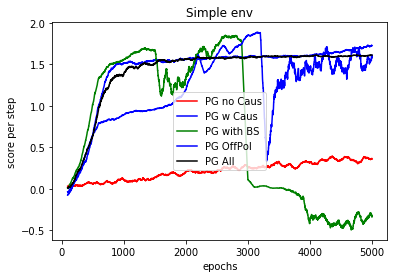

In [39]:
#plot the results (taken from https://gist.github.com/vksah32/8ba7ee7489bd8ec50c995f6216adcb7d)
import pandas as pd
import matplotlib.pyplot as plt 

mean_x1 = pd.Series(np.asarray(statsPGNCa)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x2 = pd.Series(np.asarray(statsPGwCa)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x3 = pd.Series(np.asarray(statsPGBSa)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x4 = pd.Series(np.asarray(statsPGOPa)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x5 = pd.Series(np.asarray(statsPGALLa)[:,1]).rolling(window=100).mean()/episode_lenght
itr = range(n_episodes)

plt.xlabel("epochs")
plt.ylabel("score per step")
plt.plot(itr, mean_x1, 'r-')
plt.plot(itr, mean_x2, 'b-')
plt.plot(itr, mean_x3, 'g-')
plt.plot(itr, mean_x4, 'b-')
plt.plot(itr, mean_x5, 'k-')
plt.legend(['PG no Caus', 'PG w Caus','PG with BS','PG OffPol','PG All'])
plt.title('Simple env')
plt.show()

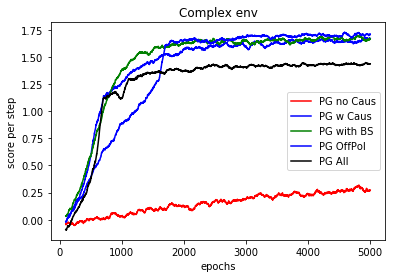

In [40]:
#plot the results (taken from https://gist.github.com/vksah32/8ba7ee7489bd8ec50c995f6216adcb7d)
import pandas as pd
import matplotlib.pyplot as plt 

mean_x1 = pd.Series(np.asarray(statsPGNCb)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x2 = pd.Series(np.asarray(statsPGwCb)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x3 = pd.Series(np.asarray(statsPGBSb)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x4 = pd.Series(np.asarray(statsPGOPb)[:,1]).rolling(window=100).mean()/episode_lenght
mean_x5 = pd.Series(np.asarray(statsPGALLb)[:,1]).rolling(window=100).mean()/episode_lenght
itr = range(n_episodes)

plt.xlabel("epochs")
plt.ylabel("score per step")
plt.plot(itr, mean_x1, 'r-')
plt.plot(itr, mean_x2, 'b-')
plt.plot(itr, mean_x3, 'g-')
plt.plot(itr, mean_x4, 'b-')
plt.plot(itr, mean_x5, 'k-')
plt.legend(['PG no Caus', 'PG w Caus','PG with BS','PG OffPol','PG All'])
plt.title('Complex env')
plt.show()